In [335]:
import math
import random
import os

import numpy as np

from comet_ml import API
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats

COMET_API_KEY="bSyRm6vJpAwfehizXic7Fo0bY"
COMET_REST_API_KEY="S3g50KZWG8zEgk1PLzKUn0eEq"


error_metric = 'standard_error' # can also be std

In [336]:
def read_conf_matrix(cm, pos_class):                                                                
    """ Calculates confusion matrix and returns true and false positives and negatives based on the 
    label specified as positive.                                                                    
                                                                                                    
    This function assumes that the classes have IDs 0, 1, 2,...                                     
                                                                                                    
    Args:                                                                                           
        y_true: True labels. 1d array or list                                                       
        y_pred: Predicted labels. 1d array or list                                                  
        classes: List of IDs of class labels. dim=n_classes                                         
        pos_class: ID of label to take as positive class                                            
                                                                                                    
    Returns:                                                                                        
        cm: confusion matrix of n_labels x n_labels                                                 
        tp: true positives                                                                          
        tn: true negatives                                                                          
        fp: false positives                                                                         
        fn: false negatives                                                                         
    """                                                                                             
    cm = np.array(cm)
    n_classes = 2
    tp = tn = fp = fn = p = n = 0
    pos_class = 1
    for row in range(n_classes):                                                                    
        for col in range(n_classes):                                                                
            if row == col:                                                                          
                if row == pos_class:                                                                
                    tp = cm[row,col]                                                                
                else:                                                                               
                    tn += cm[row,col]                                                               
            else:                                                                                   
                if col == pos_class:                                                                
                    fp += cm[row,col]                                                               
                else:                                                                               
                    fn += cm[row,col]                                                               
            if row == pos_class:        # TODO: it might be possible to optimise this and not have another if statement.
                p += cm[row, col]                                                                   
                                                                                                    
    return tp, tn, fp, fn, p, n     # TODO: function doesn't yet calculate 'n'                      

def parse_conf_mat(exp_id):
    exp = client.get_experiment_stdout(exp_id)
    confusion_mat = exp.split('Evaluate')[1].split('Confusion matrix: \n ')[1].split('Testing accuracy')[0]

    matrix = []
    for part in confusion_mat.split('\n')[2:]:
        a = part.split('[  0.   0. ')[1].replace(']','')
        a = np.array(a.split(' '))
        x = np.nonzero(a)
        matrix.append([float(str(y)) for y in a[x]])
    # make sure the numbers add up:
    assert int(np.sum(matrix)) == 312

    tp, fp = matrix[0][0], matrix[0][1]
    fn, tn = matrix[1][0], matrix[1][1]
    return matrix

def specificity(tp, tn, fp, fn, p, n):
    return tn / (tn + fp)

def recall(tp, tn, fp, fn, p, n):
    return sensitivity(tp, fp, fn, tn, p, n)
    
def sensitivity(tp,tn,fp,fn, p, n):
    return tp / p

def precision(tp,tn,fp,fn, p, n):
    return tp / (tp + fp)

def f1(args):
    pr = precision(*args)
    rc = sensitivity(*args)
    val =  (2 * pr * rc ) / ( pr + rc)
    return val


In [326]:
#API.get_experiment_metrics()
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)
experiments = client.get("co-jl-transfer/chillanto")

results = {
    'no-transfer': [],
    'human-sc': [],
    'human-sitw': [],
    'human-vctk': [],
    'nohuman-esc50': [],
    'nohuman-audioset': [],    
}

result_matrices = {
    'no-transfer': [],
    'human-sc': [],
    'human-sitw': [],
    'human-vctk': [],
    'nohuman-esc50': [],
    'nohuman-audioset': [],    
}


for exp in experiments:
    tags = client.get_experiment_tags(exp)
    
    if len(tags) > 0 and tags[0] in results.keys():
        tag = tags[0]
        metrics = client.get_experiment_metrics(exp)
        params = client.get_experiment_parameters(exp)
        for metric in metrics:
            if metric['name'] == 'test_F1':
                results[tag].append(metric['valueMax'])
        mat = read_conf_matrix(parse_conf_mat(exp), 1)
        result_matrices[tag].append(mat)

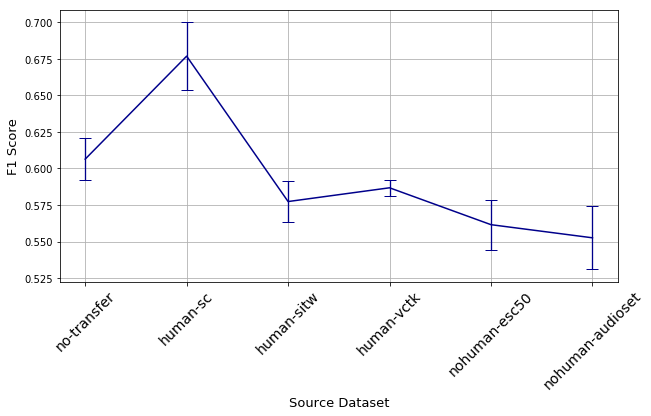

In [328]:
errors = []
xs = []
ys = []
for idx, (k, values) in enumerate(results.items()):
    xs.append(k)
    values = [float(v) for v in values]
    ys.append(np.mean(values))
    if error_metric == 'standard_error':
        errors.append(stats.sem(values))
    else:
        errors.append(np.std(values))

fig, ax = plt.subplots(figsize=(10,5))

el = ax.errorbar(xs, ys, yerr=errors, fmt='-', color='darkblue', ecolor='darkblue', elinewidth=1.3, capsize=6)
elines = el.get_children()
#elines[3].set_color('green')
ax.set_xticklabels(results.keys(), rotation=45, fontsize=14)
ax.set_ylabel('F1 Score', fontsize=13)
ax.set_xlabel('Source Dataset', fontsize=13)
plt.grid()
plt.show()




In [331]:
#API.get_experiment_metrics()
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)
experiments = client.get("co-jl-transfer/chillanto-noise")

results = {
    'gaussian': {
        'no-transfer': [],
        'human-sc': [],
    },
    'children_playing': {
        'no-transfer': [],
        'human-sc': [],
    }
}


for exp in experiments:
    noise_type = None
    for param in client.get_experiment_parameters(exp):
        if param['name'] == 'noise_type':
            noise_type = param['valueCurrent']

    if noise_type is None:
        continue

    tags = client.get_experiment_tags(exp)
    if len(tags) > 0 and tags[0] in results['gaussian'].keys():
        tag = tags[0]
        experiment = []
        metrics = client.get_experiment_metrics_raw(exp)
        for metric in metrics:
            if metric['metricName'] == 'test_F1':
                experiment.append(float(metric['metricValue']))
        results[noise_type][tag].append(experiment)

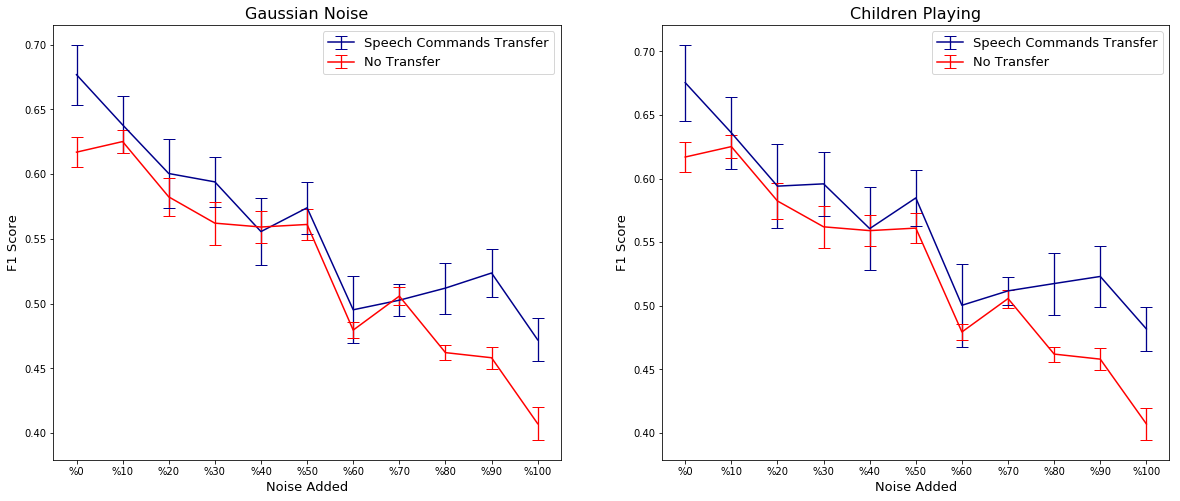

In [332]:
results_w_errors = {
    'gaussian': {},
    'children_playing': {}
}

for noise_type in results.keys():
    for source_model in results[noise_type].keys():
        mu = np.mean(results[noise_type][source_model], axis=0)
        if error_metric == 'standard_error':
            serr = stats.sem(results[noise_type][source_model], axis=0)
        else:
            std = np.std(results[noise_type][source_model], axis=0)
        
        results_w_errors[noise_type][source_model] = (mu, serr)

lines = [
    ('human-sc', 'darkblue', 'Speech Commands Transfer'),
    ('no-transfer', 'red', 'No Transfer'),    
]

fig, axs = plt.subplots(figsize=(20,8), ncols=2, sharex=True)
axs[0].set_ylabel("F1 Score", fontsize=13)
axs[1].set_ylabel("F1 Score", fontsize=13)
axs[0].set_xlabel("Noise Added", fontsize=13)
axs[1].set_xlabel("Noise Added", fontsize=13)
plt.xticks(np.arange(11), [f'%{(v) * 10}' for v in range(11)])
for idx, key in enumerate(results.keys()):
    for (line, color, label) in lines: 
        xs = np.arange(11)
        ys = results_w_errors[key][line][0]
        errors = results_w_errors[key][line][1]
        axs[idx].errorbar(xs, ys, yerr=errors, fmt='-', color=color, label=label, ecolor=color, elinewidth=1.3, capsize=6)

        
axs[0].set_title("Gaussian Noise", fontsize=16)
axs[1].set_title("Children Playing", fontsize=16)
axs[0].legend(fontsize=13)
axs[1].legend(fontsize=13)
plt.show()


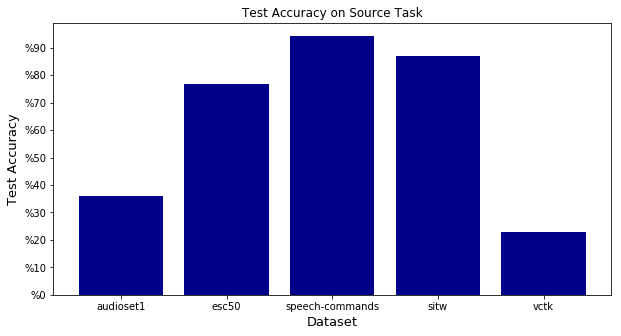

In [333]:
#API.get_experiment_metrics()
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)

projects = ('audioset1-train-and-evaluate',
            'esc50-train-and-evaluate',
            'speech-commands-train-and-evaluate',
            'sitw-train-and-evaluate',
            'vctk-train-and-evaluate')


results = {}

for project in projects:
    best_val = 0.
    experiments = client.get(f"co-jl-transfer/{project}")
    for exp in experiments:
        tags = client.get_experiment_tags(exp)
        if 'candidate' in tags:
            metrics = client.get_experiment_metrics(exp)
            for metric in metrics:
                if metric['name'] == 'test_accuracy':
                    best_val = metric['valueMax']

    results[project.replace('-train-and-evaluate','')] = float(best_val)

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(list(results.keys()), list(results.values()), color='darkblue')
plt.yticks(np.arange(10) / 10, [f'%{(v) * 10}' for v in range(10)])

ax.set_title("Test Accuracy on Source Task")
ax.set_xlabel("Dataset", fontsize=13)
ax.set_ylabel("Test Accuracy", fontsize=13)
plt.show()

In [337]:
rows = []
for key in result_matrices.keys():
    for mat in result_matrices[key]:
        ss = sensitivity(*mat)
        sp = specificity(*mat)
        pr = precision(*mat)
        f = f1(mat)
        rows.append((key, ss, sp, pr, f))
import pandas as pd


def pct(val):
    if type(val) == str:
        return val
    v = round(val * 100, 2)
    return v

def mean(val):
    x = np.mean(val)
    return f'%{round(x,2)}'

def std(val):
    x = np.std(val)
    return round(x,2)

def serr(val):
    x = stats.sem(val)
    return round(x,2)


df = pd.DataFrame(rows, columns=["Model", "Sensitivity (%)", "Specificity (%)", "Precision (%)", "F1"])
df = df.applymap(pct)
if error_metric == 'standard_error':
    table = df.groupby("Model")["Sensitivity (%)","Specificity (%)", "Precision (%)", "F1"].agg([mean, serr])
else:
    table = df.groupby("Model")["Sensitivity (%)","Specificity (%)", "Precision (%)", "F1"].agg([mean, std])
display(table)
print(table.to_latex())

Sensitivity (%)       Specificity (%)       Precision (%)  \
                            mean  serr            mean  serr          mean   
Model                                                                        
human-sc                  %78.11  5.42          %89.42  0.71        %60.16   
human-sitw                %63.02  2.28          %88.72  0.46        %53.37   
human-vctk                %63.77  1.10          %89.03  0.43         %54.4   
no-transfer               %68.55  2.52          %88.29  0.39        %54.47   
nohuman-audioset          %82.83  5.77          %74.29  5.21        %44.25   
nohuman-esc50             %61.88  2.89          %88.11  0.19        %51.48   

                            F1        
                  serr    mean  serr  
Model                                 
human-sc          1.02  %67.68  2.32  
human-sitw        1.13  %57.74  1.41  
human-vctk        0.77  %58.68  0.57  
no-transfer       0.88  %60.64  1.42  
nohuman-audioset  3.46  %55.26  2.16  
nohuman-esc50     0.94  %56.15  1.72

\begin{tabular}{llrlrlrlr}
\toprule
{} & \multicolumn{2}{l}{Sensitivity (\%)} & \multicolumn{2}{l}{Specificity (\%)} & \multicolumn{2}{l}{Precision (\%)} & \multicolumn{2}{l}{F1} \\
{} &            mean &  serr &            mean &  serr &          mean &  serr &    mean &  serr \\
Model            &                 &       &                 &       &               &       &         &       \\
\midrule
human-sc         &          \%78.11 &  5.42 &          \%89.42 &  0.71 &        \%60.16 &  1.02 &  \%67.68 &  2.32 \\
human-sitw       &          \%63.02 &  2.28 &          \%88.72 &  0.46 &        \%53.37 &  1.13 &  \%57.74 &  1.41 \\
human-vctk       &          \%63.77 &  1.10 &          \%89.03 &  0.43 &         \%54.4 &  0.77 &  \%58.68 &  0.57 \\
no-transfer      &          \%68.55 &  2.52 &          \%88.29 &  0.39 &        \%54.47 &  0.88 &  \%60.64 &  1.42 \\
nohuman-audioset &          \%82.83 &  5.77 &          \%74.29 &  5.21 &        \%44.25 &  3.46 &  \%55.26 &  2.16 \\
nohum